# Galaxy10 Classification with ResNet-50

This notebook presents a full deep learning workflow for classifying galaxy images from the Galaxy10 dataset using a ResNet-50 model. It includes custom dataset loading, preprocessing, data augmentation, model definition, training with hyperparameter tuning, and detailed performance evaluation.

The notebook also visualizes results through accuracy and loss plots, confusion matrices (both raw and normalized), and a hierarchical clustering of class embeddings based on the learned feature space. The goal is to build a high-performing and interpretable image classifier suitable for academic and research-oriented use.

## Imports and Setup

In [1]:
# Import essential libraries for data handling and visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Import PyTorch components for model building and training
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

# Import evaluation metrics from scikit-learn
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Import PCA and clustering tools for feature analysis and visualization
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
import plotly.express as px

# Additional utility imports
from PIL import Image
import os
from itertools import product
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

# Set deterministic behavior for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Dataset Preparation and Preprocessing

This section defines a custom PyTorch `Dataset` for the Galaxy10 image dataset. It loads image paths and labels from subdirectories, applies necessary transformations for ResNet-50, and prepares training, validation, and test sets. Basic dataset statistics are printed to confirm successful loading.

In [2]:
# Define a custom Dataset class for loading Galaxy10 images
class Galaxy10Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = []
        self.labels = []
        for cls_name in self.classes:
            cls_dir = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                self.images.append(os.path.join(cls_dir, img_name))
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Define base image transform for ResNet input (224x224 with normalization)
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Set path to dataset directory
data_dir = 'Galaxy10_Images'

# Create dataset instances with preprocessing
train_dataset = Galaxy10Dataset(os.path.join(data_dir, 'train'), transform=base_transform)
val_dataset = Galaxy10Dataset(os.path.join(data_dir, 'val'), transform=base_transform)
test_dataset = Galaxy10Dataset(os.path.join(data_dir, 'test'), transform=base_transform)

# Retrieve class names from the training dataset
class_names = train_dataset.classes

# Display dataset statistics
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Number of classes: {len(class_names)}")

Train set size: 15248
Validation set size: 3269
Test set size: 3268
Number of classes: 10


## Model Definition, Training Routine, and Hyperparameter Search

This section builds a ResNet-50 with a custom classification head, defines a training loop, and performs a grid search over batch sizes and optimizers to identify the best configuration. The best model is then retrained and evaluated on the test set.

In [3]:
# Build a ResNet-50 model and replace its final layer for Galaxy10 classification
def get_resnet_model(num_classes, dropout_rate=0.5):
    model = models.resnet50(weights='IMAGENET1K_V1')
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(num_ftrs, num_classes)
    )
    return model.to(device)

# Train the model and return the highest validation accuracy reached
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_preds, val_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())
        acc = accuracy_score(val_true, val_preds)
        if acc > best_acc:
            best_acc = acc
    return best_acc

# Define search space for batch size and optimizer
batch_sizes = [16, 32, 64]
optimizers = ['adam', 'sgd']
results = []

# Grid search over hyperparameters
for batch_size, opt_name in product(batch_sizes, optimizers):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    model = get_resnet_model(num_classes=len(class_names))
    criterion = nn.CrossEntropyLoss()

    if opt_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    else:
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    acc = train_model(model, train_loader, val_loader, criterion, optimizer)
    results.append({'batch_size': int(batch_size), 'optimizer': opt_name, 'accuracy': acc})

    torch.cuda.empty_cache()

# Summarize grid-search results
results_df = pd.DataFrame(results)
best_idx = results_df['accuracy'].idxmax()
best_batch_size = int(results_df.loc[best_idx, 'batch_size'])
best_optimizer = results_df.loc[best_idx, 'optimizer']

# Retrain the best configuration and evaluate on the test set
model = get_resnet_model(num_classes=len(class_names))
criterion = nn.CrossEntropyLoss()
if best_optimizer == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=0.001)
else:
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_model(model, train_loader, val_loader, criterion, optimizer)

model.eval()
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False, num_workers=0)
test_preds, test_true = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_true.extend(labels.cpu().numpy())

torch.cuda.empty_cache()
print("Grid search completed successfully!")

Grid search completed successfully!


## Hyperparameter Grid Search Results Visualization

This section creates a heatmap to visualize validation accuracy across different combinations of batch sizes and optimizers. The best-performing configuration is printed for reference.

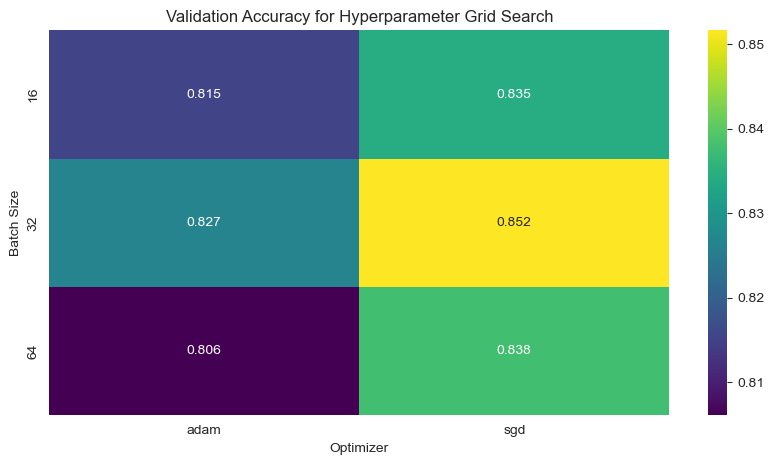

Best batch size: 32
Best optimizer: sgd


In [4]:
# Organize the grid-search results as a pivot table
pivot_table = results_df.pivot(index='batch_size', columns='optimizer', values='accuracy')

# Visualize validation accuracy across batch size and optimizer choices
plt.figure(figsize=(10, 5))
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='viridis')
plt.title('Validation Accuracy for Hyperparameter Grid Search')
plt.xlabel('Optimizer')
plt.ylabel('Batch Size')
plt.show()

print(f"Best batch size: {best_batch_size}")
print(f"Best optimizer: {best_optimizer}")

## Final Training with Augmentation and Evaluation

This section applies data augmentation to improve generalization, retrains the model using the best configuration, and tracks accuracy and loss over 200 epochs. After training, it evaluates the model on the test set using standard classification metrics.

Starting training...
Epoch 1/200 - Train Loss: 1.3128, Train Acc: 0.6331, Val Loss: 1.2250, Val Acc: 0.6522
Epoch 2/200 - Train Loss: 1.0183, Train Acc: 0.7688, Val Loss: 1.0718, Val Acc: 0.7305
Epoch 3/200 - Train Loss: 0.9474, Train Acc: 0.8006, Val Loss: 0.9764, Val Acc: 0.7905
Epoch 4/200 - Train Loss: 0.9213, Train Acc: 0.8123, Val Loss: 0.9359, Val Acc: 0.8122
Epoch 5/200 - Train Loss: 0.8980, Train Acc: 0.8214, Val Loss: 0.9311, Val Acc: 0.7972
Epoch 6/200 - Train Loss: 0.8739, Train Acc: 0.8317, Val Loss: 0.8480, Val Acc: 0.8391
Epoch 7/200 - Train Loss: 0.8607, Train Acc: 0.8382, Val Loss: 0.8476, Val Acc: 0.8394
Epoch 8/200 - Train Loss: 0.8575, Train Acc: 0.8400, Val Loss: 0.9380, Val Acc: 0.8082
Epoch 9/200 - Train Loss: 0.8357, Train Acc: 0.8492, Val Loss: 0.8596, Val Acc: 0.8357
Epoch 10/200 - Train Loss: 0.8412, Train Acc: 0.8456, Val Loss: 0.8379, Val Acc: 0.8452
Epoch 11/200 - Train Loss: 0.8235, Train Acc: 0.8534, Val Loss: 0.9009, Val Acc: 0.8116
Epoch 12/200 - Train

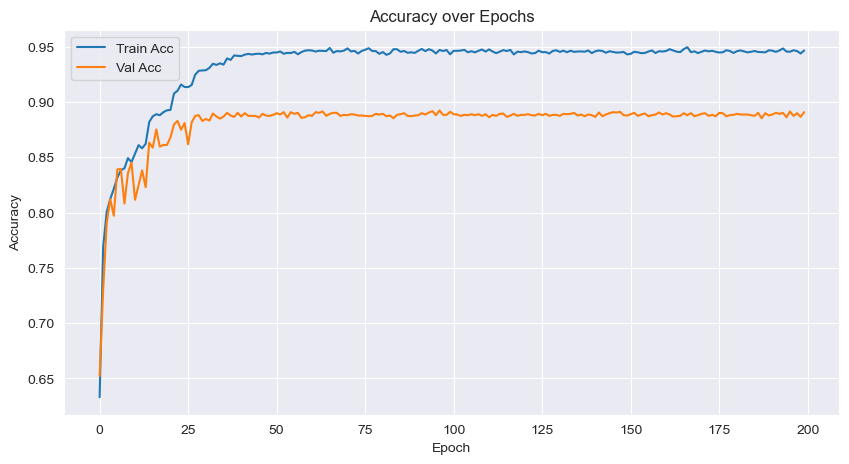

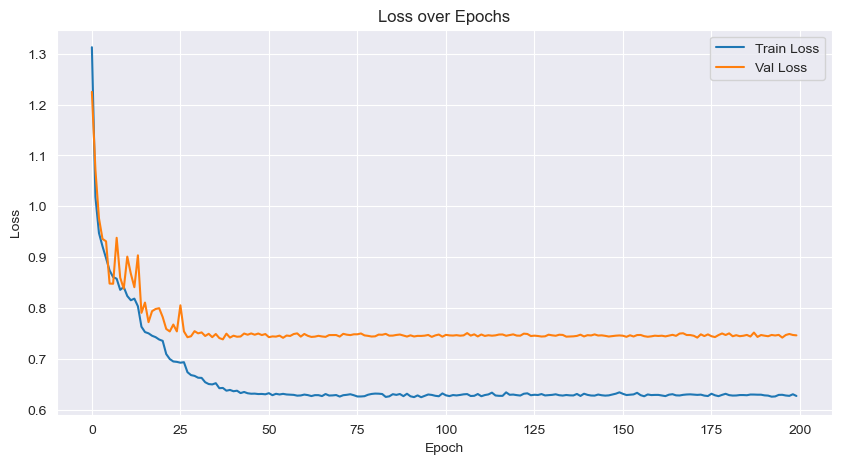

Test Accuracy: 0.908812729498164
Test Balanced Accuracy: 0.7869831908938719
Test Precision: 0.9071785221100279
Test Recall: 0.908812729498164
Test F1 Score: 0.9076034705597634


In [5]:
# Define data-augmentation pipeline for the training set
aug_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create datasets and data loaders
aug_train_dataset = Galaxy10Dataset(os.path.join(data_dir, 'train'), transform=aug_transform)
train_loader = DataLoader(aug_train_dataset, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,      batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,     batch_size=32, shuffle=False, num_workers=0)

# Initialize model, loss, optimizer, and scheduler
model     = get_resnet_model(num_classes=len(class_names), dropout_rate=0.3)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training parameters
num_epochs     = 200
train_acc_list = []
val_acc_list   = []
train_loss_list = []
val_loss_list   = []

print("Starting training...")
for epoch in range(num_epochs):
    # --- Train phase ---
    model.train()
    running_loss, total_samples = 0.0, 0
    train_preds, train_true = [], []
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        train_preds.extend(outputs.argmax(1).cpu().numpy())
        train_true.extend(labels.cpu().numpy())
        total_samples += inputs.size(0)

    train_acc_list.append(accuracy_score(train_true, train_preds))
    train_loss_list.append(running_loss / total_samples)

    # --- Validation phase ---
    model.eval()
    val_loss, total_samples = 0.0, 0
    val_preds, val_true = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_preds.extend(outputs.argmax(1).cpu().numpy())
            val_true.extend(labels.cpu().numpy())
            total_samples += inputs.size(0)

    val_acc_list.append(accuracy_score(val_true, val_preds))
    val_loss_list.append(val_loss / total_samples)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss_list[-1]:.4f}, Train Acc: {train_acc_list[-1]:.4f}, "
          f"Val Loss: {val_loss_list[-1]:.4f}, Val Acc: {val_acc_list[-1]:.4f}")

    torch.cuda.empty_cache()

# Plot accuracy and loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label="Train Acc")
plt.plot(val_acc_list,   label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the trained model on the test set
model.eval()
test_preds, test_true = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_preds.extend(outputs.argmax(1).cpu().numpy())
        test_true.extend(labels.cpu().numpy())

print("Test Accuracy:",            accuracy_score(test_true, test_preds))
print("Test Balanced Accuracy:",   balanced_accuracy_score(test_true, test_preds))
print("Test Precision:",           precision_score(test_true, test_preds, average='weighted'))
print("Test Recall:",              recall_score(test_true, test_preds, average='weighted'))
print("Test F1 Score:",            f1_score(test_true, test_preds, average='weighted'))

torch.cuda.empty_cache()

## Classification Report

Generates a full precision-recall-F1 summary for each class, providing a detailed view of per-class performance on the test set.

In [6]:
# Display a detailed classification report
print("\nClassification Report:")
print(classification_report(test_true, test_preds, target_names=class_names))


Classification Report:
                   precision    recall  f1-score   support

    barred_spiral       0.84      0.80      0.82       136
     cigar_smooth       0.93      0.92      0.92       944
  edgeon_no_bulge       0.86      0.71      0.78        52
edgeon_with_bulge       0.94      0.97      0.95       230
 inbetween_smooth       0.94      0.97      0.96      1050
           merger       0.83      0.86      0.84        78
     round_smooth       0.84      0.80      0.82       519
     spiral_loose       0.85      0.91      0.88       168
    spiral_medium       0.89      0.93      0.91        88
     spiral_tight       0.00      0.00      0.00         3

         accuracy                           0.91      3268
        macro avg       0.79      0.79      0.79      3268
     weighted avg       0.91      0.91      0.91      3268



## Confusion Matrix Visualization

Plots two confusion matrices: one with raw prediction counts and another with row-normalized percentages. These visualizations help assess which classes the model confuses most often.

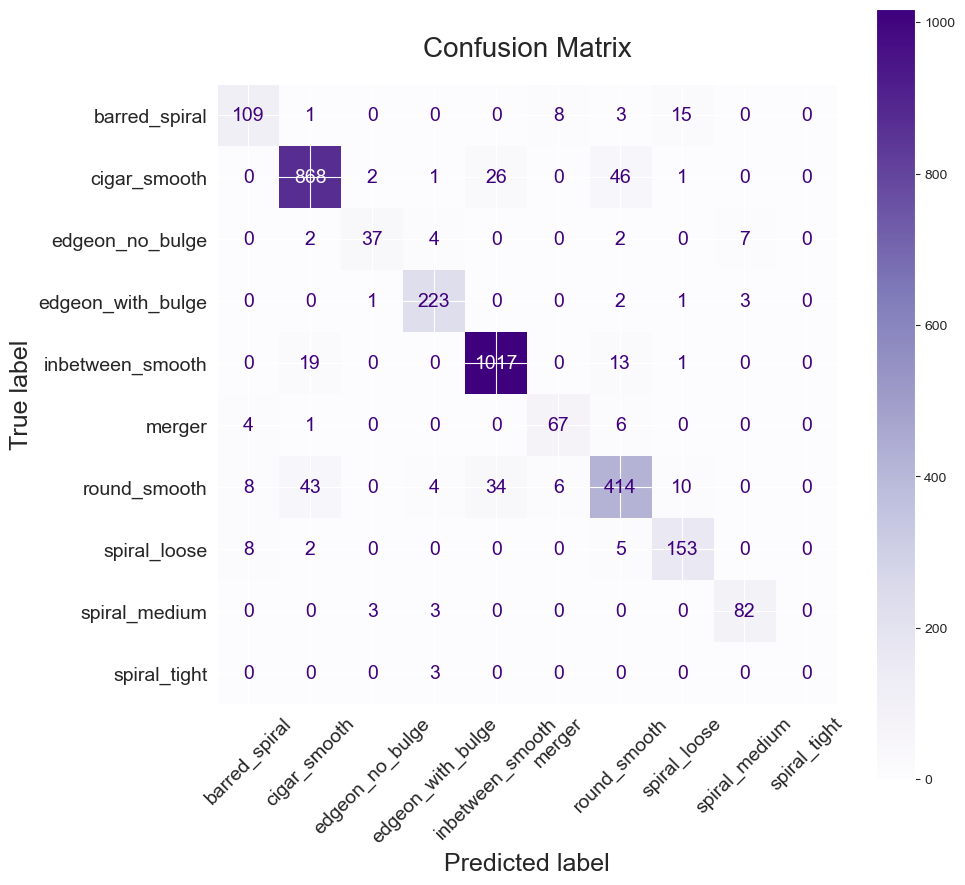

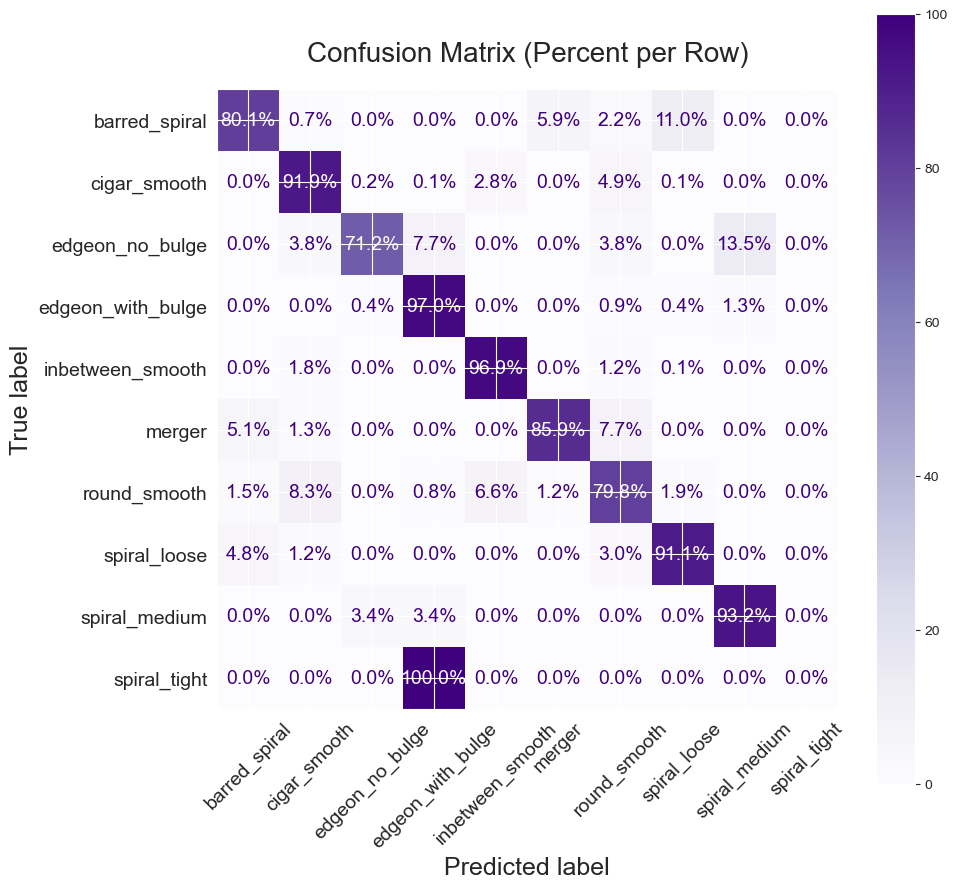

In [7]:
# Plot confusion matrix with raw prediction counts
cm = confusion_matrix(test_true, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Purples', xticks_rotation=45)

ax.set_title("Confusion Matrix", fontsize=20, pad=20)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.tick_params(axis='both', labelsize=14)
for text in disp.text_.ravel():
    text.set_fontsize(14)

plt.show()

# Plot confusion matrix with row-normalized percentages
cm_percent = cm.astype(float) / cm.sum(axis=1)[:, None] * 100
disp_percent = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp_percent.plot(ax=ax, cmap='Purples', xticks_rotation=45, values_format='.1f')

for text in disp_percent.text_.ravel():
    text.set_text(f"{float(text.get_text()):.1f}%")
    text.set_fontsize(14)

ax.set_title("Confusion Matrix (Percent per Row)", fontsize=20, pad=20)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.tick_params(axis='both', labelsize=14)

plt.show()

## Hierarchical Clustering of Predicted Classes

We analyzed how the model groups Galaxy10 classes by performing hierarchical clustering based on the **mean embedding** (centroid) of each **predicted class** in the test set.

For each class that was actually predicted by the model, we computed its centroid by averaging the embeddings of all test samples assigned to that class. This approach reflects how the model internally organizes its predictions in feature space.

We used **Ward’s method** on the pairwise **Euclidean distances** between class centroids:

$$
\text{Distance}(C_i, C_j) = \left\| \mu_i - \mu_j \right\|_2
$$

This method reveals how semantically close the predicted classes are according to the model’s learned representation.

> Note: Classes not predicted at all are excluded from the dendrogram.

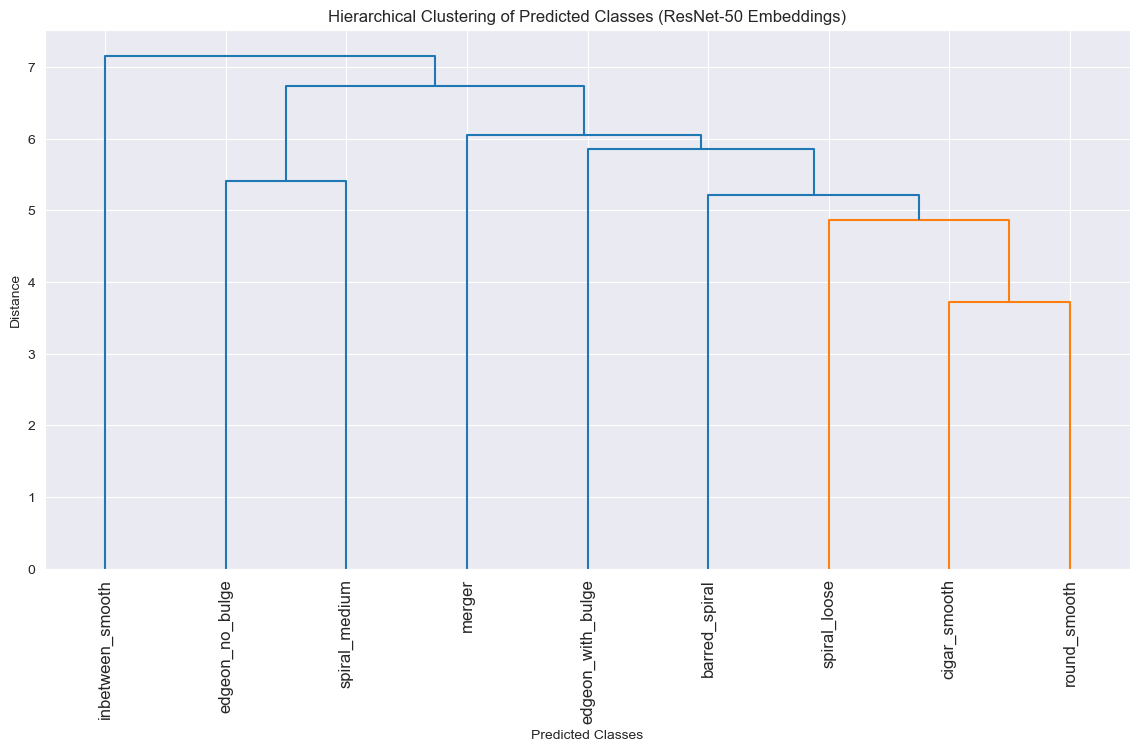

In [8]:
# Extract embeddings and predictions for the test set
model.eval()
feature_extractor = nn.Sequential(*list(model.children())[:-1]).to(device)  # Remove final classification layer

test_emb_list, test_pred_list = [], []

with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        feats = feature_extractor(x).flatten(1)  # Extract features of shape (B, 2048)
        logits = model.fc(feats)  # Compute class scores
        preds = logits.argmax(1)  # Get predicted class indices
        test_emb_list.append(feats.cpu())
        test_pred_list.append(preds.cpu())

# Combine all batch results
test_embeddings = torch.cat(test_emb_list).numpy()  # Shape: (N, 2048)
test_preds = torch.cat(test_pred_list).numpy()  # Shape: (N,)

# Compute centroids for each predicted class
class_names = np.array(class_names)
centroids_pred, valid_class_names_pred = [], []
for cls in np.unique(test_preds):
    idx = np.where(test_preds == cls)[0]  # Indices for the current class
    centroids_pred.append(test_embeddings[idx].mean(axis=0))
    valid_class_names_pred.append(class_names[cls])
centroids_pred = np.vstack(centroids_pred)

# Perform hierarchical clustering and plot dendrogram
linked_pred = linkage(centroids_pred, method='ward')
plt.figure(figsize=(14, 7))
dendrogram(linked_pred, labels=valid_class_names_pred, leaf_rotation=90)
plt.title('Hierarchical Clustering of Predicted Classes (ResNet-50 Embeddings)')
plt.xlabel('Predicted Classes')
plt.ylabel('Distance')
plt.show()